# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import helpers
from slam import get_residual, get_my_jacob, get_jax_jacob, calc_init_poses, LM


## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

Estimate using odometry


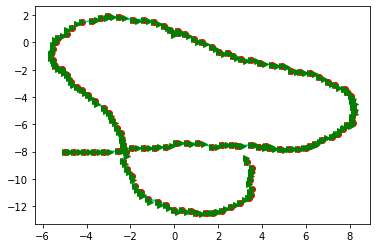

In [2]:

EDGES_FILE = '../data/edges.txt'
EDGES_POSES_FILE = '../data/edges-poses.g2o'

nodes, edges = helpers.read_data(EDGES_FILE)
fixed = nodes[:, 0]
poses = calc_init_poses(fixed, edges)
print("Estimate using odometry")
helpers.draw_one(poses[:, 0], poses[:, 1], poses[:, 2])
helpers.write_edges_poses(EDGES_POSES_FILE, EDGES_FILE, poses)


## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

Comparing Jacobians
Frobenius norm between my jacobian and jax jacobian is: 0.0


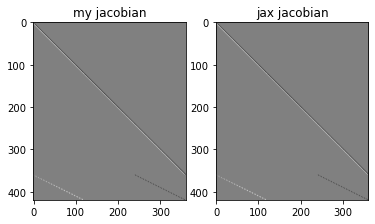

In [3]:
def compare_jacobs():
    my_jacob = get_my_jacob(poses, edges, fixed)
    jax_jacob = get_jax_jacob(poses, edges, fixed)

    print("Comparing Jacobians")
    helpers.frobNorm(my_jacob, jax_jacob, "my jacobian", "jax jacobian")
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(my_jacob, cmap='gray')
    ax[1].imshow(jax_jacob, cmap='gray')
    ax[0].set_title('my jacobian')
    ax[1].set_title('jax jacobian')
    plt.show()

compare_jacobs()


Using Weights: (10, 25.0, 40)

Iteration 0: Error: 22834.7109375


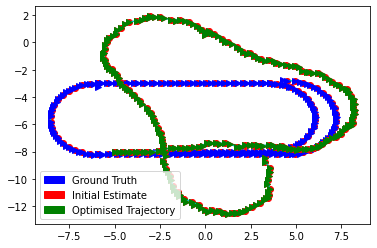

Iteration 1: Error: 4219.79052734375
Iteration 2: Error: 643.3182373046875
Iteration 3: Error: 448.1934814453125
Iteration 4: Error: 216.72422790527344
Iteration 5: Error: 108.32759094238281
Iteration 6: Error: 311.2138671875
Iteration 7: Error: 376.2975769042969
Iteration 8: Error: 638.9488525390625
Iteration 9: Error: 1146.0897216796875
Iteration 10: Error: 317.9783020019531


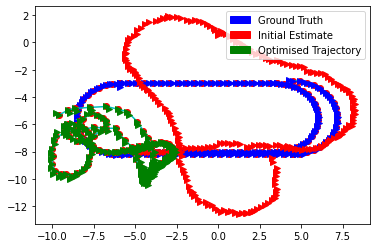

Iteration 11: Error: 63.66074752807617
Iteration 12: Error: 29.843355178833008
Iteration 13: Error: 20.931367874145508
Iteration 14: Error: 20.71017074584961
Iteration 15: Error: 23.01817512512207
Iteration 16: Error: 25.24036979675293
Iteration 17: Error: 21.42579460144043
Iteration 18: Error: 15.912029266357422
Iteration 19: Error: 14.590655326843262
Iteration 20: Error: 15.749907493591309


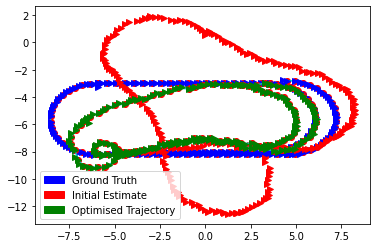

Iteration 21: Error: 15.045183181762695
Iteration 22: Error: 13.972550392150879
Iteration 23: Error: 14.901055335998535
Iteration 24: Error: 18.238840103149414
Iteration 25: Error: 22.489303588867188
Iteration 26: Error: 24.579797744750977
Iteration 27: Error: 21.686185836791992
Iteration 28: Error: 17.606428146362305
Iteration 29: Error: 22.923023223876953
Iteration 30: Error: 31.048851013183594


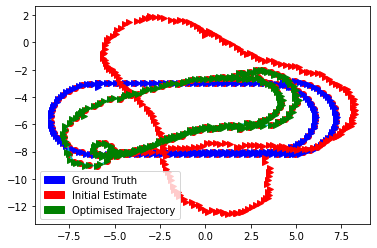

Iteration 31: Error: 26.573097229003906
Iteration 32: Error: 18.029943466186523
Iteration 33: Error: 16.81635093688965
Iteration 34: Error: 27.032445907592773
Iteration 35: Error: 51.709835052490234
Iteration 36: Error: 94.64523315429688
Iteration 37: Error: 144.0518341064453
Iteration 38: Error: 133.05194091796875
Iteration 39: Error: 49.81397247314453
Iteration 40: Error: 59.740657806396484


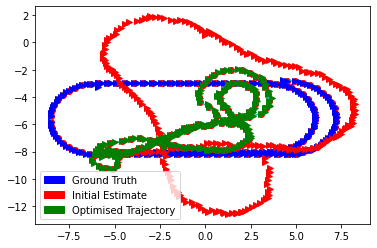

Iteration 41: Error: 146.6272430419922
Iteration 42: Error: 203.14158630371094
Iteration 43: Error: 139.9993438720703
Iteration 44: Error: 58.65082931518555
Iteration 45: Error: 26.986730575561523
Iteration 46: Error: 32.306941986083984
Iteration 47: Error: 74.95640563964844
Iteration 48: Error: 189.05531311035156
Iteration 49: Error: 459.1143493652344
Iteration 50: Error: 709.5502319335938


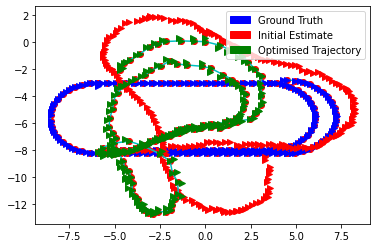

Iteration 51: Error: 317.21771240234375
Iteration 52: Error: 190.53506469726562
Iteration 53: Error: 183.44337463378906
Iteration 54: Error: 76.32989501953125
Iteration 55: Error: 152.69198608398438
Iteration 56: Error: 146.14926147460938
Iteration 57: Error: 111.11266326904297
Iteration 58: Error: 65.66886138916016
Iteration 59: Error: 33.92823028564453
Iteration 60: Error: 20.342132568359375


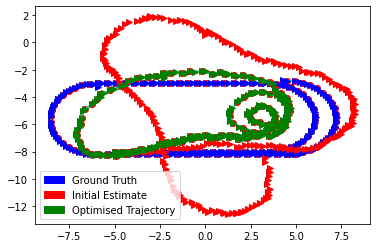

Iteration 61: Error: 16.795167922973633
Iteration 62: Error: 16.181737899780273
Iteration 63: Error: 16.105945587158203
Iteration 64: Error: 16.105342864990234
Iteration 65: Error: 16.11126708984375
Iteration 66: Error: 16.11516571044922
Iteration 67: Error: 16.1173038482666
Iteration 68: Error: 16.118593215942383
Iteration 69: Error: 16.119518280029297
Iteration 70: Error: 16.120275497436523


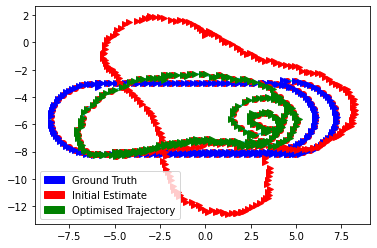

Iteration 71: Error: 16.120941162109375
Iteration 72: Error: 16.12151527404785
Iteration 73: Error: 16.122034072875977
Iteration 74: Error: 16.12246322631836
Iteration 75: Error: 16.12285041809082
Iteration 76: Error: 16.1231689453125
Iteration 77: Error: 16.123422622680664
Iteration 78: Error: 16.123634338378906
Iteration 79: Error: 16.12381362915039
Iteration 80: Error: 16.123958587646484


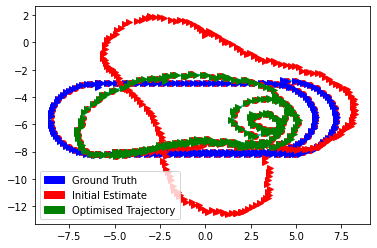

Iteration 81: Error: 16.124073028564453
Iteration 82: Error: 16.124164581298828
Iteration 83: Error: 16.124248504638672
Iteration 84: Error: 16.124311447143555
Iteration 85: Error: 16.124359130859375
Iteration 86: Error: 16.124399185180664
Iteration 87: Error: 16.12444305419922
Iteration 88: Error: 16.124462127685547
Iteration 89: Error: 16.124486923217773
Iteration 90: Error: 16.12449836730957


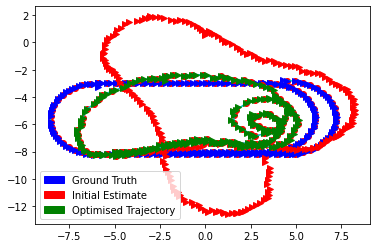

Iteration 91: Error: 16.124507904052734
Iteration 92: Error: 16.1245174407959
Iteration 93: Error: 16.1245174407959
Iteration 94: Error: 16.12452507019043
Iteration 95: Error: 16.124528884887695
Iteration 96: Error: 16.124534606933594
Iteration 97: Error: 16.12455177307129
Iteration 98: Error: 16.124544143676758
Iteration 99: Error: 16.124549865722656
Iteration 100: Error: 16.124540328979492


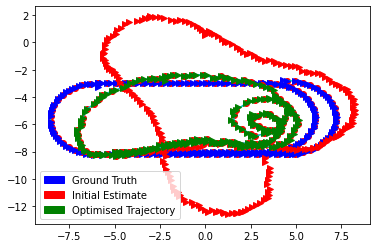

Final Error: 16.124540328979492 at itr: 101


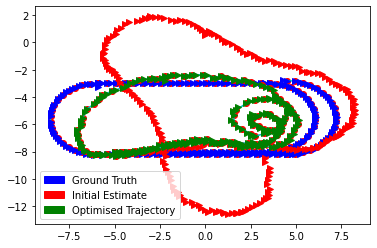

In [7]:
lm = LM(poses,edges, fixed, 0.01, 61, 1e-6, [2.5,4])
poses_arr, error_arr = lm.optimize()

min error: 13.972550392150879 with following poses


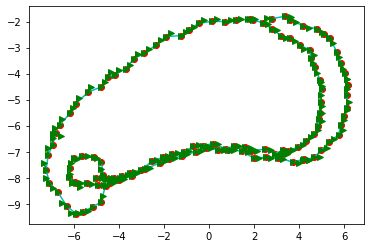

final error: 16.124540328979492 with following poses


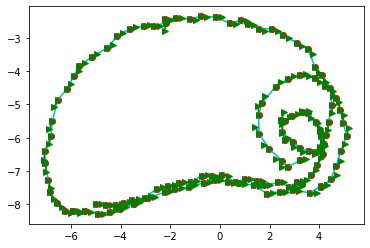

In [8]:
for t, i in [("min", np.argmin(error_arr)), ("final", -1)]:
    print(f"{t} error: {error_arr[i]} with following poses")
    helpers.draw_one(poses_arr[i][:, 0], poses_arr[i]
                     [:, 1], poses_arr[i][:, 2])

Using Weights: (10, 1000, 1000)

min error: 13.646923065185547 with following poses


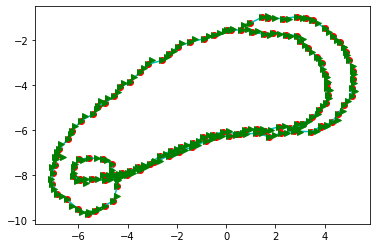

final error: 5531.34765625 with following poses


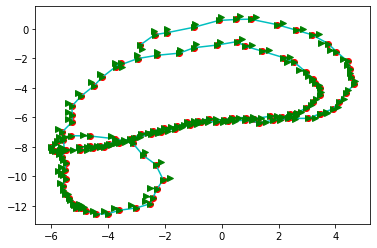

Using Weights: (10, 10, 100)

min error: 11.924837112426758 with following poses


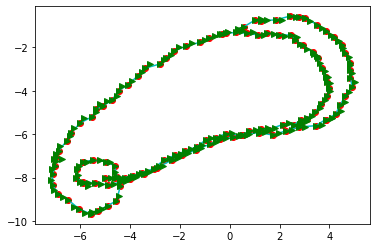

final error: 27.28851890563965 with following poses


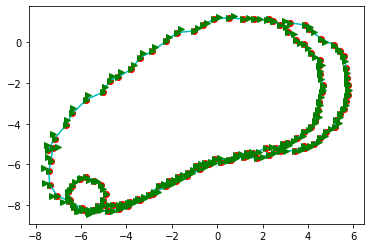

Using Weights: (10, 30, 50)

min error: 12.79140853881836 with following poses


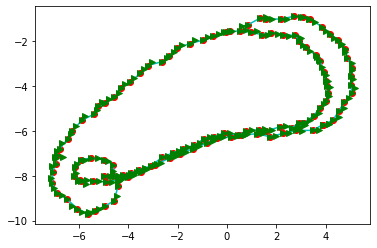

final error: 174.55906677246094 with following poses


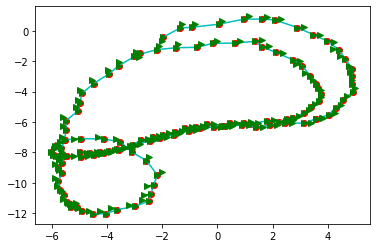

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

### Residual
- Structure: [anchor odometry_contraints loop_contraints].T   where anchor is the fixed position for pose0, and odometry and loop contraints are edge contraints.
- Shape: `(1 + edges_cnt)*3 X 1` . because edges_cnt = loop_contraint + odometry_contriant and one for anchor. 3 is the number of parameters to define a pose.

### Jacobian
The Jacobian is calculated by stacking partial derivatives wrt to all the parameters to be optimized. In current scenario, the parameters are the (x,y,theta) of all the poses of the robot.

$\mathbf{J}=\frac{\partial \mathbf{f}}{\partial \mathbf{X}}=\left(\frac{\partial \mathbf{f}}{\partial \mathbf{x}_{0}} \frac{\partial \mathbf{f}}{\partial \mathbf{x}_{1}} \cdots \frac{\partial \mathbf{f}}{\partial \mathbf{x}_{n}}\right)$
- Shape: `contraints_cnt` $\times$ `vars_cnt`, where  
    - `contraints_cnt` = (1 + edges_cnt)*3 
    - `vars_cnt` = poses_cnt * 3

### Optimization Process
There are many hyperparameters in the optimization like the lambda, tolerance and the iterations for the LM algorithm, but the most important values are of the information matrix, because it was ultimately deciding which contraint should have how much weight while optimization. If we treat the loop contraints to be more important than the odometric ones (due to the type of sensor which measured the data), then we got better results. But we can not keep the loop_contraints weight arbitrarily high since that would undermine the information provided by the odometry. The following results confirm the claim.



![finals errors](final_err.png "finals errors")


## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [9]:
helpers.write_edges_poses("../data/opt.g2o", EDGES_FILE, poses_arr[np.argmin(error_arr)])